In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install Transformers tokenizers datasets evaluate rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=91f8fc9ec6fb2edcff5bf868e58deac6313cf799d53b0e954bcbfae775d9cf76
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [3]:
import re
import string
import unicodedata
from random import randint
from nltk.tokenize import sent_tokenize

from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import evaluate


2024-06-22 22:53:17.951953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 22:53:17.952086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 22:53:18.081331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import torch
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.get_device_name(0))  # Display GPU name

True
Tesla P100-PCIE-16GB


In [5]:
# if torch.cuda.is_available():
#   generator = torch.Generator('cuda').manual_seed(42)
# else:
#   generator = torch.Generator().manual_seed(42)

# !CUDA_LAUNCH_BLOCKING=1

In [6]:
def extract_pandas_df(transcript,description):
    trans_vid_id = []
    trans_desc = []
    with open(transcript,'r') as t:
        A = t.readline()
        while A != "":
            B = A.split()
            trans_vid_id.append(B[0])
            trans_desc.append(" ".join(B[1:]))
            A = t.readline()
    
    desc_vid_id = []
    desc_desc = []
    with open(description,'r') as d:
        C = d.readline()
        while C != "":
            D = C.split()
            desc_vid_id.append(D[0])
            desc_desc.append(" ".join(D[1:]))
            C = d.readline()
            
    df1 = pd.DataFrame({'Video_id':trans_vid_id,"Vid_Transcript":trans_desc})
    df2 = pd.DataFrame({'Video_id':desc_vid_id,"Vid_summary":desc_desc})
    
    df = pd.merge(df1,df2,how = 'inner',on = 'Video_id')
    return df

In [7]:
train = extract_pandas_df('/kaggle/input/how2-extracted-dataset/tmp_en_sum_4407145a-6de3-418f-95a1-f82ff2c470ee/text/sum_train/tran.tok.txt','/kaggle/input/how2-extracted-dataset/tmp_en_sum_4407145a-6de3-418f-95a1-f82ff2c470ee/text/sum_train/desc.tok.txt')
val = extract_pandas_df('/kaggle/input/how2-extracted-dataset/tmp_en_sum_4407145a-6de3-418f-95a1-f82ff2c470ee/text/sum_cv/tran.tok.txt','/kaggle/input/how2-extracted-dataset/tmp_en_sum_4407145a-6de3-418f-95a1-f82ff2c470ee/text/sum_cv/desc.tok.txt')
test = extract_pandas_df('/kaggle/input/how2-extracted-dataset/tmp_en_sum_4407145a-6de3-418f-95a1-f82ff2c470ee/text/sum_devtest/tran.tok.txt','/kaggle/input/how2-extracted-dataset/tmp_en_sum_4407145a-6de3-418f-95a1-f82ff2c470ee/text/sum_devtest/desc.tok.txt')

## Here you can save these dataset's into their respective config directory

In [8]:
## You can also use load_dataset feature to combine the dataset and load it from the specific directory

from datasets import Dataset

ds_train = Dataset.from_pandas(train,split='train')
ds_val = Dataset.from_pandas(val,split='val')
ds_test = Dataset.from_pandas(test,split='test')

In [9]:
print(ds_train)
print(ds_val)
ds_test

Dataset({
    features: ['Video_id', 'Vid_Transcript', 'Vid_summary'],
    num_rows: 68336
})
Dataset({
    features: ['Video_id', 'Vid_Transcript', 'Vid_summary'],
    num_rows: 2520
})


Dataset({
    features: ['Video_id', 'Vid_Transcript', 'Vid_summary'],
    num_rows: 2127
})

In [10]:
pip install contractions

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


dddd

In [11]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [12]:

def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Whatcha doing?")

'What are you doing?'

In [13]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [14]:
# Cleaning text
def clean_text(text):
    text = expand_contractions(text)
    text = text.lower()
    text = rm_punc_from_text(text)
    
    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text
print(ds_train['Vid_summary'][1])
clean_text(ds_train['Vid_summary'][1])

using front layers as a guide , cut back layers into curly hair . learn to cut layers in curly hair with expert tips from a hairstylist in this free video about curly hairstyles .


'using front layers as guide cut back layers into curly hair learn to cut layers in curly hair with expert tips from hairstylist in this free video about curly hairstyles'

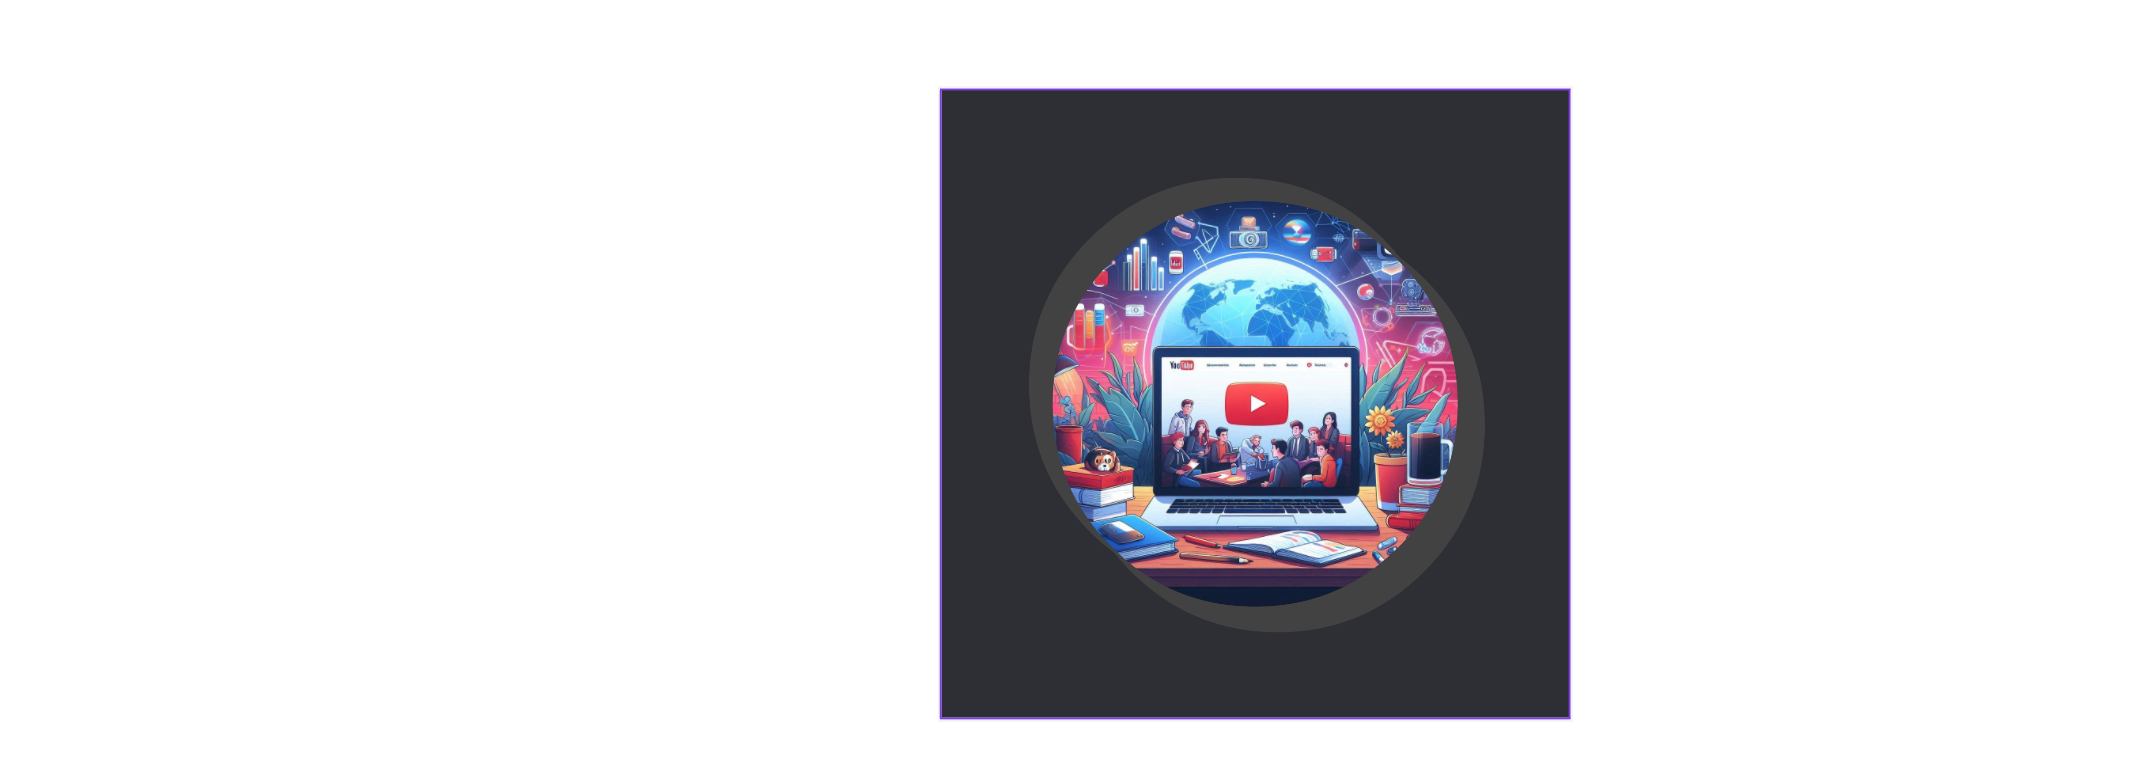

In [15]:
def clean_dataset(ds):
    ds = ds.map(lambda x: {"Vid_summary": [clean_text(o) for o in x["Vid_summary"]]}, batched=True, num_proc = 8)

    # Apply the clean_text function to the Vid_Transcript column
    ds = ds.map(lambda x: {"Vid_Transcript": [clean_text(o) for o in x["Vid_Transcript"]]}, batched=True, num_proc = 8)
    
    return ds

In [16]:
ds_train = clean_dataset(ds_train)
ds_val = clean_dataset(ds_val)
ds_test = clean_dataset(ds_test)

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=8):   0%|          | 0/68336 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=8):   0%|          | 0/68336 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2520 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2520 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2127 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2127 [00:00<?, ? examples/s]

In [17]:
from datasets import DatasetDict

dataset_dict = {
    'train' : ds_train,
    'test': ds_test,
    'validation': ds_val
}

data = DatasetDict(dataset_dict)
data

DatasetDict({
    train: Dataset({
        features: ['Video_id', 'Vid_Transcript', 'Vid_summary'],
        num_rows: 68336
    })
    test: Dataset({
        features: ['Video_id', 'Vid_Transcript', 'Vid_summary'],
        num_rows: 2127
    })
    validation: Dataset({
        features: ['Video_id', 'Vid_Transcript', 'Vid_summary'],
        num_rows: 2520
    })
})

In [18]:
from transformers import AutoTokenizer

model_checkpoint = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [19]:
inputs = tokenizer("Hi I am a Data Scientist!")
inputs

{'input_ids': [0, 30086, 38, 524, 10, 5423, 37774, 328, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [20]:
max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["Vid_Transcript"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["Vid_summary"], max_length=max_target_length, truncation=True
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [21]:
final_data = data.map(preprocess_function, batched =True,
                     remove_columns=['Video_id', 'Vid_Transcript', 'Vid_summary'],num_proc = 8)

Map (num_proc=8):   0%|          | 0/68336 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2127 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2520 [00:00<?, ? examples/s]

In [22]:
final_data

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 68336
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2127
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2520
    })
})

In [100]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained('/kaggle/input/model-summarizer')

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7ee8da694790>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7ee81455dc30, raw_cell="from transformers import AutoModelForSeq2SeqLM

mo.." store_history=True silent=False shell_futures=True cell_id=f31c2bd2-5f57-469f-9078-94a5adfe6e22>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7ee8da694790>> (for post_run_cell), with arguments args (<ExecutionResult object at 7ee81455e950, execution_count=100 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7ee81455dc30, raw_cell="from transformers import AutoModelForSeq2SeqLM

mo.." store_history=True silent=False shell_futures=True cell_id=f31c2bd2-5f57-469f-9078-94a5adfe6e22> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [24]:
import evaluate

rouge_score = evaluate.load("rouge")

In [99]:
batch_size = 4
epochs = 3
model_name = f"{model_checkpoint}-transcript-summarizer"
args = Seq2SeqTrainingArguments(
    model_name,                                                        # Specify Model name
    evaluation_strategy="epoch",                                       # Evaluate performance at Epoch end
    learning_rate=5.6e-5,                            
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01, 
    save_total_limit=3,                                                # Save the model only 3 times
    num_train_epochs=epochs,                                           # Number of Epochs
    predict_with_generate=True,                                        # To predict Sequences
    fp16=True,                                                         # Set to fp16, mixed precision training
    push_to_hub=False                                                  # Push model to huggingface
)

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7ee8da694790>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7ee81455dcf0, raw_cell="batch_size = 4
epochs = 3
model_name = f"{model_ch.." store_history=True silent=False shell_futures=True cell_id=297af3cf-f4f9-4e12-a5aa-546d4fffc366>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7ee8da694790>> (for post_run_cell), with arguments args (<ExecutionResult object at 7ee81455d9c0, execution_count=99 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7ee81455dcf0, raw_cell="batch_size = 4
epochs = 3
model_name = f"{model_ch.." store_history=True silent=False shell_futures=True cell_id=297af3cf-f4f9-4e12-a5aa-546d4fffc366> result=None>,),kwargs {}:


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


BrokenPipeError: [Errno 32] Broken pipe

In [86]:
import numpy as np
from nltk.tokenize import sent_tokenize

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key : value * 100 for key, value in result.items()}
    
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v,4) for k,v in result.items()}

In [87]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)


In [88]:
features = [final_data['train'][i] for i in range(1)]
data_collator(features)

{'input_ids': tensor([[    0,  3592,  3370, 41906, 12003,   225,    31,     5,  1437,  2617,
          5444,  3254,  5259,     8,  1236,  2678,  2590,  7822,   225,   175,
            65,     9,     5,  1142,    33,    57,   553,   149,     5,   107,
           141,   109,    47,  2807,  1437,  2617,  1808,    24,   269, 23653,
            24,  7971,    15,    99,   110,   724,    16,    32,    47,   667,
             7,   120,    11,   357,  3989,   109,    47,   236,     7,  1532,
          1403,  1443,   109,    47,   236,     7,  3511,    50,    32,    47,
            95,  2509,    11,     5,  2536,  1795,     9,     5,  1437,  2617,
          5444,   904,    47,  2536,  1795,   215,    25,  1403,  2123,  1403,
          8882,  1403,   797,  2098,    98,    89,    16,   319,     9, 25083,
            11,   127,  1508,    77,    82,   224,    99,  2496,    16,   275,
            99,  2496,   197,   109,     5,   129,  2496,    14,    16,   269,
           505,    16,     5,  5307,  

In [89]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=final_data['train'],
    eval_dataset=final_data['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# import shutil
# shutil.rmtree("/kaggle/working/facebook/bart-large-cnn-transcript-summarizer/checkpoint-17000")

In [98]:
trainer.train()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7ee8da694790>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 7ee814e7a7d0, raw_cell="trainer.train()" store_history=True silent=False shell_futures=True cell_id=fa25277c-90e9-4e4a-98fb-a260be5f9587>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

Epoch,Training Loss,Validation Loss


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7ee8da694790>> (for post_run_cell), with arguments args (<ExecutionResult object at 7ee814fb53f0, execution_count=98 error_before_exec=None error_in_exec=[Errno 32] Broken pipe info=<ExecutionInfo object at 7ee814e7a7d0, raw_cell="trainer.train()" store_history=True silent=False shell_futures=True cell_id=fa25277c-90e9-4e4a-98fb-a260be5f9587> result=None>,),kwargs {}:


BrokenPipeError: [Errno 32] Broken pipe

In [31]:
# model.evaluate(final_data['test'])

In [ ]:
model.save_pretrained("dummy")

In [52]:
from transformers import pipeline
model = '/kaggle/working/dummy'

pipe = pipeline('summarization',model=model,tokenizer=tokenizer)

# pipe("hi everybody i 'm john graden from the martial arts teacher 's association and johngraden.com . one of the questions i have been asked through the years how do you choose a martial art ? it really varies it depends on what your goal is . are you trying to get in better shape , do you want to learn self defense , do you want to compete or are you just interested in the mental benefits of the martial arts offer you , mental benefits such as self confidence , self discipline , self control , respect , so there is a lot of variables . in my mind when people say what style is best , what style should i do the only style that is really important is the teaching style of the instructor . so how do you choose a good martial arts ? it is really more about choosing a good martial arts instructor , it 's about choosing a good martial arts school , so when you are going to make the decision make sure first you know what your goal is . if you really want a strong self defense oriented system you want to be working with an instructor who may have a police background a law enforcement background , some practical application in street self defense . if you are just looking to become a martial artist or a good black belt here is the key . you want to go and visit and watch the students , watch the beginner students and study in particular the teaching style of the instructor . how does that instructor interact with the students , how does that instructor conduct a class ? then go look at the advanced students . we want to make sure that they 're impressive , we want to make sure that they 're in shape , we want to make sure there is lots of them . what does that mean if there is lots of advanced students ? that means the school has a high retention . that means that it is a good school or she is a good instructor and she is able to keep her students for a long time . when you have a school that has lots of brown and black belts and they are impressive then you know you have an instructor that has a curriculum designed to keep students in the school so the teaching style is the most important style of any martial art . there are a variety of different styles , tai kwon do , kempo , kung fu , karate , i 'm not that interested in the style , i 'm interested in the teacher , making sure that teacher can help me or you to reach your goals . i 'm john graden for the martial arts teacher 's association . thanks . tune in for more martial arts excitement . thanks .")

In [60]:
from builtins import input

ipt = input("Enter Text")

Enter Text hi everybody i 'm john graden from the martial arts teacher 's association and johngraden.com . one of the questions i have been asked through the years how do you choose a martial art ? it really varies it depends on what your goal is . are you trying to get in better shape , do you want to learn self defense , do you want to compete or are you just interested in the mental benefits of the martial arts offer you , mental benefits such as self confidence , self discipline , self control , respect , so there is a lot of variables . in my mind when people say what style is best , what style should i do the only style that is really important is the teaching style of the instructor . so how do you choose a good martial arts ? it is really more about choosing a good martial arts instructor , it 's about choosing a good martial arts school , so when you are going to make the decision make sure first you know what your goal is . if you really want a strong self defense oriented sy

In [61]:
ipt = clean_text(ipt)

In [65]:
pipe(ipt)[0]['summary_text']

'choosing ial arts instructor depends on the type of ial art learn how to choose an instructor in this free video on   sports teacher association member tttddsdddanananlanlsananaa'

In [ ]:
import time
import random
import datetime

def perform_task():
    """Perform a simple task to keep the notebook active."""
    # Generate a random number and perform a simple calculation
    num = random.randint(1, 1000)
    result = num ** 2
    
    # Get current timestamp
    current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Print a message with the result and timestamp
    print(f"[{current_time}] Keeping notebook active. Random calculation: {num}^2 = {result}")

def keep_notebook_alive(duration_hours=2):
    """Keep the notebook alive for the specified duration."""
    end_time = time.time() + (duration_hours * 3600)  # Convert hours to seconds
    
    print(f"Starting keep-alive script. Will run for {duration_hours} hours.")
    
    while time.time() < end_time:
        perform_task()
        
        # Sleep for a random interval between 1 and 5 minutes
        sleep_time = random.randint(60, 300)
        time.sleep(sleep_time)
    
    print("Keep-alive script completed.")


Keep_notebook_alive(2)  # Run for 2 hours

In [71]:
!pip install transformers --upgrade

In [79]:
from transformers import pipeline

pipe = pipeline("text-to-speech", model="suno/bark-small")

text = "Ladybugs have had important roles in culture and religion, being associated with luck, love, fertility and prophecy. "
output = pipe(text)

from IPython.display import Audio

Audio(output["audio"], rate=output["sampling_rate"])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:10000 for open-end generation.
